# King et al 2020 E-T-L

**Authorship:**<br>
Created by: Adam Klie, *11/18/2022*
Last updated: Adam Klie, *11/18/2022*
***
**Description:**

***

In [145]:
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload 
%autoreload 2

import os
import numpy as np
import pandas as pd
import eugene as eu

# Configure EUGENe 
print(eu.__version__)
eu.settings.dataset_dir = "/cellar/users/aklie/data/eugene" 
eu.settings.logging_dir = "/cellar/users/aklie/projects/EUGENe/tests/_logs/king20"
eu.settings.output_dir = "/cellar/users/aklie/projects/EUGENe/tests/_output/king20"

0.0.4


# Load data

## `king20()` dataset function

In [146]:
def king20(
    dataset = "SYN", 
    return_sdata=True, 
    **kwargs: dict
):
    urls_list = [
        "https://elifesciences.org/download/aHR0cHM6Ly9jZG4uZWxpZmVzY2llbmNlcy5vcmcvYXJ0aWNsZXMvNDEyNzkvZWxpZmUtNDEyNzktc3VwcDEtdjIueGxzeA--/elife-41279-supp1-v2.xlsx?_hash=nX7V5q5UXEGDbCoqhF23ru1RNUI14CBnHk27Cxlpgr4%3D",
        "https://elifesciences.org/download/aHR0cHM6Ly9jZG4uZWxpZmVzY2llbmNlcy5vcmcvYXJ0aWNsZXMvNDEyNzkvZWxpZmUtNDEyNzktc3VwcDItdjIueGxzeA--/elife-41279-supp2-v2.xlsx?_hash=V%2FARKgB5fn%2FUe1zKqVdBFHuq7na8rU%2BuFcWIQQwnAPM%3D"
    ]
    paths = [
        os.path.join(eu.settings.dataset_dir, "king20", "design.xlsx"),
        os.path.join(eu.settings.dataset_dir, "king20", "models.xlsx")
    ]
    print(f"Downloading king20 to {paths[0]}")
    os.system("wget -q -O {0} {1}".format(paths[0], urls_list[0]))
    print(f"Finished downloading king20 to {paths[0]}")
    print(f"Downloading king20 to {paths[1]}")
    os.system("wget -q -O {0} {1}".format(paths[1], urls_list[1]))
    print(f"Finished downloading king20 to {paths[1]}")
    if dataset == "SYN":
        seq_tbl = pd.read_excel(paths[0], sheet_name=1)
        seq_tbl_filt = seq_tbl[~seq_tbl["Sequence"].duplicated()]
        model_tbl = pd.read_excel(paths[1], sheet_name=4)
        merged_tbl = pd.merge(seq_tbl_filt, model_tbl, on="Element_id", how="outer")
    elif dataset == "GEN":
        seq_tbl = pd.read_excel(paths[0], sheet_name=6)
        seq_tbl_filt = seq_tbl[~seq_tbl["Sequence"].duplicated()]
        model_tbl = pd.read_excel(paths[1], sheet_name=5)
    else:
        raise ValueError("dataset must be either 'SYN' or 'GEN'.")
    if return_sdata:
        seq_col = "Sequence"
        sdata = eu.dl.SeqData(
            seqs=merged_tbl["Sequence"],
            names=merged_tbl["Element_id"],
            seqs_annot=merged_tbl.drop("Barcode", axis=1).set_index("Element_id")
        )
        return sdata
    else:
        return paths

In [147]:
sdata = king20("SYN")

Finished downloading king20 to /cellar/users/aklie/data/eugene/king20/design.xlsx
Finished downloading king20 to /cellar/users/aklie/data/eugene/king20/models.xlsx


## Data Visualization

In [148]:
# Add this to sanitize seqs
sdata = sdata[~np.array([seq is np.nan for seq in sdata.seqs])]

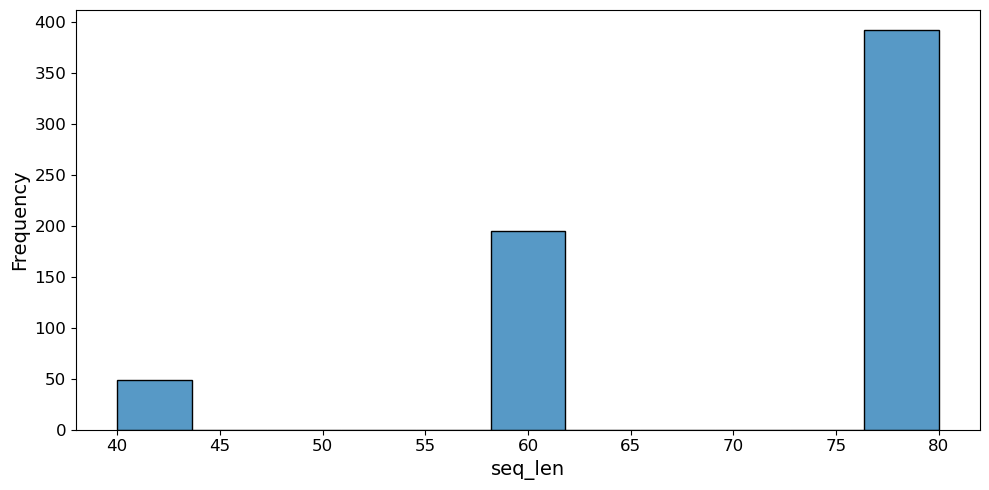

In [150]:
# Add this to some kind of preprocess seqs or seqs metrics
sdata["seq_len"] = [len(seq) for seq in sdata.seqs]
eu.pl.histplot(
    sdata, 
    keys="seq_len", 
    orient="h"
)

12


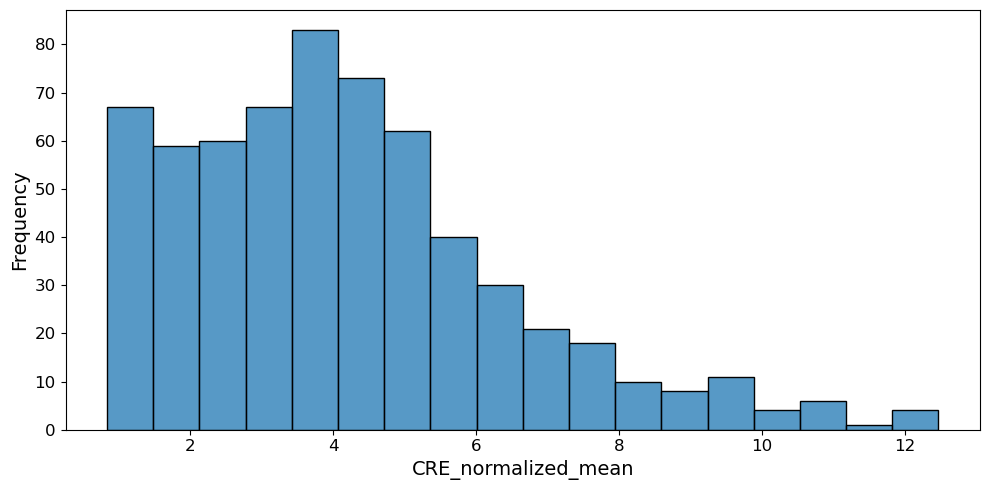

In [157]:
# Chceck the potential target to start
eu.pl.histplot(
    sdata,
    keys="CRE_normalized_mean",
    orient="h"
)
print(sdata["CRE_normalized_mean"].isna().sum())

## Preprocessing

In [158]:
# One-hot-encode, though this is no bueno
eu.pp.ohe_seqs_sdata(sdata, maxlen=sdata["seq_len"].max())

In [159]:
# Add function registry for normalization
sdata["log_CRE_normalized_mean"] = np.log2(sdata["CRE_normalized_mean"])

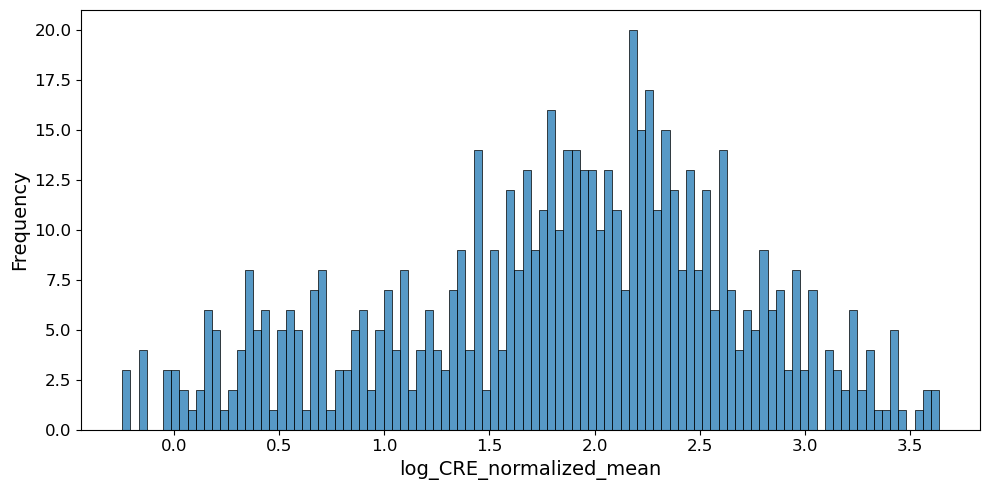

In [160]:
# Check log normalization
eu.pl.histplot(
    sdata,
    keys="log_CRE_normalized_mean",
    orient="h",
    bins=100
)

In [161]:
# Clean up features to use
sdata.seqs_annot = sdata.seqs_annot.replace({True: 1, False: 0})

In [186]:
feature_cols = sdata.seqs_annot.columns[sdata.seqs_annot.columns.str.contains("presence|Position")]
sdata.seqsm["independent_position_features"] = sdata.seqs_annot[feature_cols].values

In [187]:
sdata.seqsm["independent_position_features"]

array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 1.]])

In [219]:
eu.pp.train_test_split_sdata(sdata, split=0.5)

# Training

## Initialization

In [236]:
model = RandomForestRegressor(random_state=13)

## `fit()`

In [243]:
from sklearn.ensemble import RandomForestRegressor
from eugene._settings import settings
import threading

def fit(
    model,
    sdata,
    target_keys,
    train_key="train_val",
    features_cols = None,
    seqsm_key = None,
    threads=None,
    log_dir=None,
    name=None,
    version=None,
    seed=None,
    verbosity=None
):
    # Set-up the run
    threads = threads if threads is not None else threading.active_count()
    log_dir = log_dir if log_dir is not None else settings.logging_dir
    model_name = model.__class__.__name__
    name = name if name is not None else model_name
    np.random.seed(seed) if seed is not None else np.random.seed(settings.seed)
    
    # Remove seqs with NaN targets
    targs = sdata.seqs_annot[target_keys].values  
    if len(targs.shape) == 1:
        nan_mask = np.isnan(targs)
    else:
        nan_mask = np.any(np.isnan(targs), axis=1)
    print(f"Dropping {nan_mask.sum()} sequences with NaN targets.")
    sdata = sdata[~nan_mask]
    targs = targs[~nan_mask]
    
    # Get train and val indeces
    train_idx = np.where(sdata.seqs_annot[train_key] == True)[0]
    val_idx = np.where(sdata.seqs_annot[train_key] == False)[0]
    
    # Get train and val targets
    train_Y = targs[train_idx].squeeze()
    val_Y = targs[val_idx].squeeze()
    
    # Get train adn val features
    if feature_cols is not None:
        sdata.seqsm[f"{model_name}_features"] = sdata.seqs_annot[feature_cols].values
    else:
        assert seqsm_key is not None
    features = sdata.seqsm[seqsm_key]
    train_X = features[train_idx]
    val_X = features[val_idx]
    model.fit(train_X, val_X)

In [244]:
fit(
    model,
    sdata,
    target_keys = "log_CRE_normalized_mean",
    train_key = "train_val",
    seqsm_key = "independent_position_features"
)

Dropping 0 sequences with NaN targets.


# Evaluation

In [245]:
def predictions(
    model,
    sdata,
    target_keys,
    features_cols = None,
    seqsm_key = None,
    threads=None,
    store_only=False,
    out_dir=None,
    name=None,
    version="",
    file_label="",
    prefix="",
    suffix="",
    copy=False
):
    threads = threads if threads is not None else threading.active_count()
    target_keys = [target_keys] if type(target_keys) == str else target_keys
    out_dir = out_dir if out_dir is not None else settings.output_dir
    model_name = model.__class__.__name__
    name = name if name is not None else model_name
    out_dir = os.path.join(out_dir, name, version)
    
    if feature_cols is not None:
        sdata.seqsm[f"{model_name}_features"] = sdata.seqs_annot[feature_cols].values
    else:
        assert seqsm_key is not None
    features = sdata.seqsm[seqsm_key]
    
    ps = np.concatenate(model.predict(features), axis=0)
    num_outs = model.output_dim
    preds = pd.DataFrame(index=ps[:, 0], data=ps[:, 1 : num_outs + 1])
    sannot_cols = [f"{prefix}{lab}_predictions{suffix}" for lab in target_keys]
    ordered_preds = preds.loc[sdata.seqs_annot.index].astype(float)
    sdata.seqs_annot[sannot_cols] = ordered_preds
    return sdata if copy else None

SyntaxError: invalid syntax (3925206765.py, line 13)

In [ ]:
target_keys = "log_CRE_normalized_mean"
seqsm_key = "independent_position_features"

In [229]:
sdata["predictions"] = clf.predict(features)

In [230]:
sdata

SeqData object with = 624 seqs
seqs = (624,)
names = (624,)
rev_seqs = None
ohe_seqs = (624, 4, 80)
ohe_rev_seqs = None
seqs_annot: 'Sequence', 'Element_id_simplified', 'Class', 'CRE_normalized_mean', 'O_presence', 'S_presence', 'K_presence', 'E_presence', 'Position.4_O', 'Position.4_S', 'Position.4_K', 'Position.4_E', 'Position.3_O', 'Position.3_S', 'Position.3_K', 'Position.3_E', 'Position.2_O', 'Position.2_S', 'Position.2_K', 'Position.2_E', 'Position.1_O', 'Position.1_S', 'Position.1_K', 'Position.1_E', 'seq_len', 'log_CRE_normalized_mean', 'train_val', 'predictions'
pos_annot: None
seqsm: 'independent_position_features'
uns: None

Group R2 MSE Spearmanr
2mer 0.5161002958979524 0.09063900660280101 0.7556371078703835
3mer 0.49745103578438 0.13292124302224156 0.7141220022464215
4mer 0.6349499695298852 0.09679782383175593 0.7768950361766365


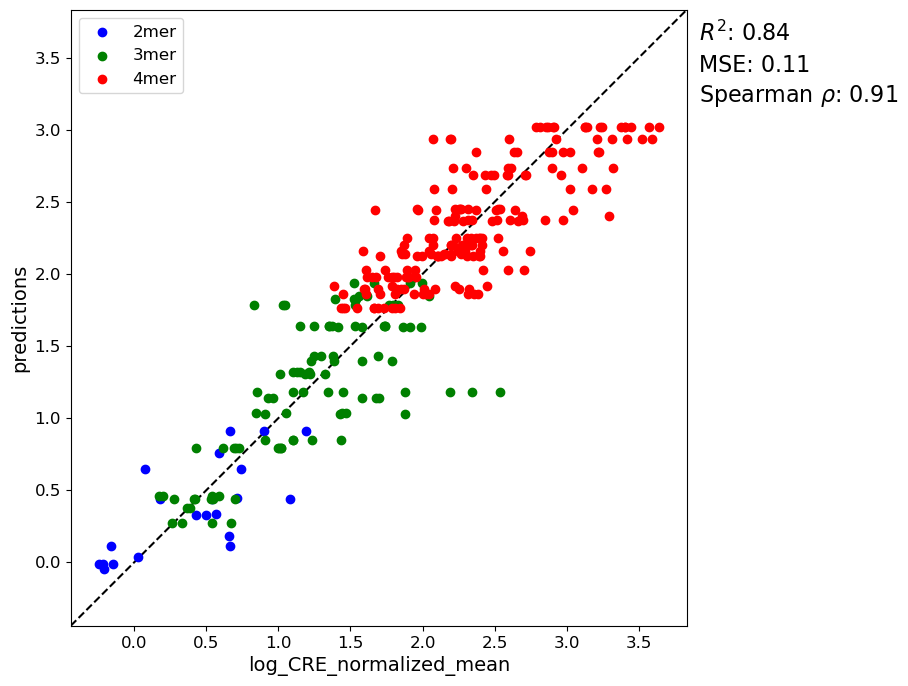

In [231]:
eu.pl.performance_scatter(
    sdata,
    target_keys="log_CRE_normalized_mean",
    prediction_keys="predictions",
    seq_idx=val_idx,
    groupby="Class"
)

# Interpretation

## Feature attribution

---